## Libraries

In [1]:
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer

import pandas as pd

import torch
from torch.utils.data import DataLoader

from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

from emotion_dataset import EmotionDataset
from rnn_lstm_model import RNN_LSTM_model

from loader import loader
from train_model import train_model
from plot_scores import plot_scores
from predict import predict
from predict_on_fly import predict_on_fly

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)

from collections import Counter
from itertools import chain

c:\Users\henri\miniconda3\envs\deep\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## Load and save dataset

In [3]:
labels_csv_path = "data/labels.csv"
train_csv_path = "data/train.csv"
val_csv_path = "data/val.csv"
test_csv_path = "data/test.csv"

data = loader(labels_csv_path, train_csv_path, val_csv_path, test_csv_path)

train_df = data["train"]
val_df = data["val"]
test_df = data["test"]
labels_df = data["labels"]

# Task 1: Data Preparation

## Data set

In [4]:
# Print number of examples
print(f"# train sentences: {len(train_df)}")
print(f"# validation sentences: {len(val_df)}")
print(f"# test sentences: {len(test_df)}")
print(f"\n{labels_df.to_string(index=False)}")

# train sentences: 16000
# validation sentences: 2000
# test sentences: 2000

 Index   Labels
     0  sadness
     1      joy
     2     love
     3    anger
     4     fear
     5 surprise


## Step 1: Dataset Preparation

### Label distribution

Number of classes: 6
Label Mapping: {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

Training Label Distribution:
text_label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


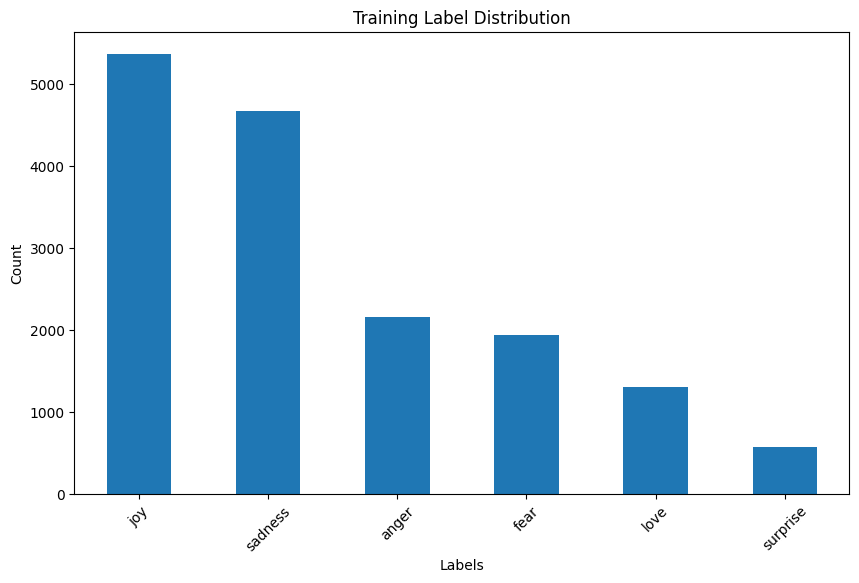

In [5]:
# Create a mapper for label numbers to text labels
num_classes = labels_df["Labels"].size
print(f"Number of classes: {num_classes}")
label_mapping = {index: label for index, label in labels_df.values}
print("Label Mapping:", label_mapping)

# Map numeric labels to text labels in the train, validation, and test sets
train_df["text_label"] = train_df["label"].map(label_mapping)
val_df["text_label"] = val_df["label"].map(label_mapping)
test_df["text_label"] = test_df["label"].map(label_mapping)

# Print the label distribution for training set
train_label_counts = train_df["text_label"].value_counts()
print("\nTraining Label Distribution:")
print(train_label_counts)

# Plot the label distribution
plt.figure(figsize=(10, 6))
train_label_counts.plot(kind="bar")
plt.title("Training Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Step 2: Tokenizing

### Tokenizer

In [6]:
tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+|[!?'´`]+") # characters that don’t match the pattern act as separators.
example_sentence = "This?.is,a:custom;tokenization example!<"
example_tokens = tokenizer.tokenize(example_sentence)
print(example_tokens)

['This', '?', 'is', 'a', 'custom', 'tokenization', 'example', '!']


### Tokenize each split

In [7]:
train_tokens = [tokenizer.tokenize(text.lower()) for text in train_df["text"]]
val_tokens = [tokenizer.tokenize(text.lower()) for text in val_df["text"]]
test_tokens = [tokenizer.tokenize(text.lower()) for text in test_df["text"]]

train_vocab = set(token for tokens in train_tokens for token in tokens)

print(f"# words in train vocab: {len(train_vocab)}")

# words in train vocab: 15212


### Sentence length distribution

Length range for train: from 2 to 66 words
Mean length for train: 19 words
Standard deviation for train: 121


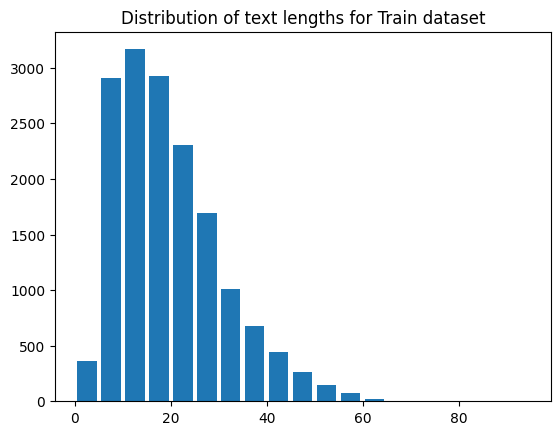

In [8]:
train_lengths = [len(tokens) for tokens in train_tokens]

print(f"Length range for train: from {min(train_lengths)} to {max(train_lengths)} words")
print(f"Mean length for train: {sum(train_lengths) / len(train_lengths):.0f} words")
print(f"Standard deviation for train: {sum([(length - sum(train_lengths) / len(train_lengths)) ** 2 for length in train_lengths]) / len(train_lengths):.0f}")

plt.hist(train_lengths, bins=range(0, 100, 5), rwidth=0.8)
plt.title("Distribution of text lengths for Train dataset")
plt.show()

### Word frequency

In [9]:
top_n = 10

flat_tokens = list(chain.from_iterable(train_tokens))
most_common_word_counts = Counter(flat_tokens).most_common(top_n)
print(pd.DataFrame(most_common_word_counts, columns=["Word", "Count"]).to_string(index=False))

   Word  Count
      i  25859
   feel  11183
    and   9589
     to   8972
    the   8370
      a   6200
feeling   5112
   that   5112
     of   4990
     my   4283


## Step 3: Build a vocabulary

In [10]:
vocab = {"<PAD>": 0, "<UNK>": 1}
for tokens in train_tokens:
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab)

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

reverse_vocab = {v: k for k, v in vocab.items()}

Vocabulary size: 15214


## Step 4: Encode all texts with the vocabulary

In [11]:
def encode_text(tokens): # i.e. words to integers
    return [vocab[token] if token in vocab else 1 for token in tokens]

train_encoded = [encode_text(tokens) for tokens in train_tokens]
val_encoded = [encode_text(tokens) for tokens in val_tokens]
test_encoded = [encode_text(tokens) for tokens in test_tokens]

## Step 5: Maximum sequence length

In [12]:
# Make all sentences equal length.
# If too small add zeroes at the end.
# If too long cut the end of the sentence.

max_length = 23

def pad_sequence(sequence):
    return sequence[:max_length] + [0] * (max_length - len(sequence))

train_padded = [pad_sequence(sequence) for sequence in train_encoded]
val_padded = [pad_sequence(sequence) for sequence in val_encoded]
test_padded = [pad_sequence(sequence) for sequence in test_encoded]

# Task 2: RNN model

Epoch 1/10 | Train Loss: 107.1785 (acc. 32.1%) | Val Loss: 1.5807 (acc. 35.2%) | Time: 3s
Epoch 2/10 | Train Loss: 50.3424 (acc. 32.82%) | Val Loss: 1.5805 (acc. 35.2%) | Time: 3s
Epoch 3/10 | Train Loss: 23.9834 (acc. 33.54%) | Val Loss: 1.5948 (acc. 28.65%) | Time: 3s
Epoch 4/10 | Train Loss: 11.6235 (acc. 34.37%) | Val Loss: 1.5562 (acc. 41.15%) | Time: 3s
Epoch 5/10 | Train Loss: 5.6936 (acc. 52.11%) | Val Loss: 1.0765 (acc. 57.6%) | Time: 3s
Epoch 6/10 | Train Loss: 2.8682 (acc. 64.69%) | Val Loss: 0.7817 (acc. 69.7%) | Time: 3s
Epoch 7/10 | Train Loss: 1.54 (acc. 75.97%) | Val Loss: 0.5617 (acc. 78.5%) | Time: 3s
Epoch 8/10 | Train Loss: 0.9368 (acc. 84.98%) | Val Loss: 0.5061 (acc. 80.7%) | Time: 3s
Epoch 9/10 | Train Loss: 0.674 (acc. 88.04%) | Val Loss: 0.3662 (acc. 86.9%) | Time: 3s
Epoch 10/10 | Train Loss: 0.5488 (acc. 89.84%) | Val Loss: 0.3408 (acc. 87.45%) | Time: 3s
Total Training Time: 30s

Accuracy Score: 0.8745
F1-Score: 0.8741
Precision: 0.8759
Recall: 0.8745

Class

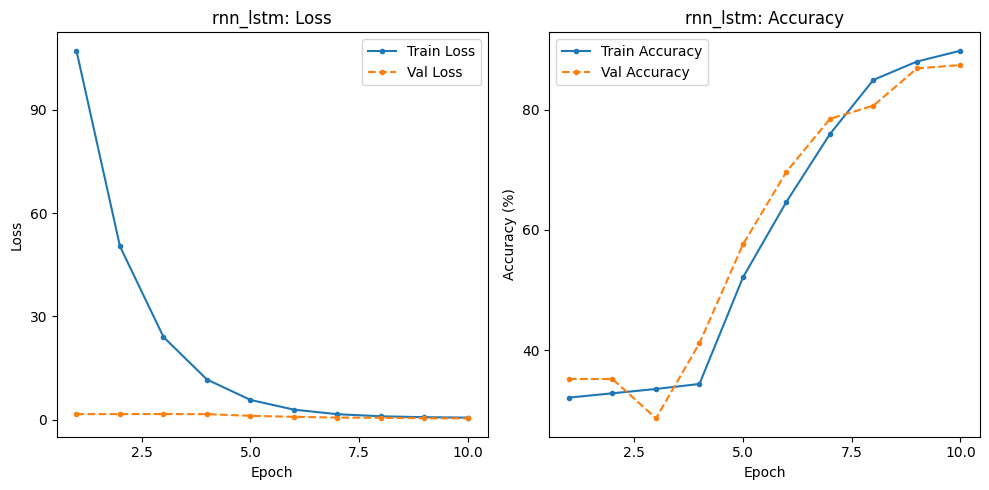

In [13]:
embedding_dim = 100
hidden_dim = 256
model = RNN_LSTM_model(vocab_size, embedding_dim, hidden_dim, num_classes)

batch_size = 32

train_labels = train_df["label"].tolist()
val_labels = val_df["label"].tolist()
train_dataset = EmotionDataset(train_padded, train_labels)
val_dataset = EmotionDataset(val_padded, val_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

label = "rnn_lstm"
num_epochs = 10
learning_rate = 0.001

results = train_model(
    label=label,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    label_mapping=label_mapping,
    device=device,
    optimizer_type="Adam",
    learning_rate=learning_rate,
    weight_decay=0.0,
    reg_type="L2",
    reg_lambda=1e-4,
    num_epochs=num_epochs
)

plot_scores(results, label)

In [14]:
predict_on_fly(
    model=model,
    tokenizer=tokenizer,
    vocab=vocab,
    device=device,
    label_map=label_mapping,
    max_length=max_length
)

Type 'q' to quit.
Exiting...


# Task 3: Transformer model

# Task 4: Analysis

In [15]:
test_labels = test_df["label"].tolist()
test_dataset = EmotionDataset(test_padded, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

predict(label, model, device, test_loader, label_mapping, reverse_vocab)

# Task 5: Pre-trained model

In [16]:
# Hugging Face Trainer expects the data to be in a specific format
def helper_function(text, max_length=max_length):
    tokens = tokenizer.tokenize(text.lower())
    token_ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(token_ids) < max_length:
        token_ids += [vocab["<PAD>"]] * (max_length - len(token_ids))
    else:
        token_ids = token_ids[:max_length]
    return {
        "input_ids": token_ids,
        "attention_mask": [1 if i < len(tokens) else 0 for i in range(max_length)]
    }

# Preprocess train and validation datasets
train_data = [{**helper_function(text), "label": label} for text, label in zip(train_df["text"], train_labels)]
val_data = [{**helper_function(text), "label": label} for text, label in zip(val_df["text"], val_labels)]
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=7,
    weight_decay=0.01,
    save_total_limit=1, # only last checkpoint is saved
)

# Define model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=labels_df["Labels"].size)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Fine-tune model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 14%|█▍        | 500/3500 [00:46<04:34, 10.92it/s]

{'loss': 1.5894, 'grad_norm': 2.028961420059204, 'learning_rate': 2.5714285714285714e-05, 'epoch': 1.0}


                                                  
 14%|█▍        | 502/3500 [00:48<23:31,  2.12it/s]

{'eval_loss': 1.5880920886993408, 'eval_runtime': 1.3987, 'eval_samples_per_second': 1429.94, 'eval_steps_per_second': 45.043, 'epoch': 1.0}


 29%|██▊       | 1000/3500 [01:34<03:50, 10.84it/s]

{'loss': 1.4896, 'grad_norm': 9.269027709960938, 'learning_rate': 2.1428571428571428e-05, 'epoch': 2.0}


                                                   
 29%|██▊       | 1002/3500 [01:37<20:04,  2.07it/s]

{'eval_loss': 1.2235910892486572, 'eval_runtime': 1.4028, 'eval_samples_per_second': 1425.757, 'eval_steps_per_second': 44.911, 'epoch': 2.0}


 43%|████▎     | 1500/3500 [02:23<03:04, 10.84it/s]

{'loss': 1.0764, 'grad_norm': 75.5252685546875, 'learning_rate': 1.7142857142857142e-05, 'epoch': 3.0}


                                                   
 43%|████▎     | 1502/3500 [02:26<16:13,  2.05it/s]

{'eval_loss': 0.9345896244049072, 'eval_runtime': 1.4111, 'eval_samples_per_second': 1417.325, 'eval_steps_per_second': 44.646, 'epoch': 3.0}


 57%|█████▋    | 2000/3500 [03:12<02:18, 10.85it/s]

{'loss': 0.7834, 'grad_norm': 15.047965049743652, 'learning_rate': 1.2857142857142857e-05, 'epoch': 4.0}


                                                   
 57%|█████▋    | 2002/3500 [03:15<12:01,  2.08it/s]

{'eval_loss': 0.7170396447181702, 'eval_runtime': 1.4127, 'eval_samples_per_second': 1415.715, 'eval_steps_per_second': 44.595, 'epoch': 4.0}


 71%|███████▏  | 2500/3500 [04:01<01:32, 10.84it/s]

{'loss': 0.581, 'grad_norm': 16.83642578125, 'learning_rate': 8.571428571428571e-06, 'epoch': 5.0}


                                                   
 71%|███████▏  | 2502/3500 [04:04<08:01,  2.07it/s]

{'eval_loss': 0.6222363710403442, 'eval_runtime': 1.3984, 'eval_samples_per_second': 1430.209, 'eval_steps_per_second': 45.052, 'epoch': 5.0}


 86%|████████▌ | 3000/3500 [04:50<00:46, 10.76it/s]

{'loss': 0.4409, 'grad_norm': 22.690818786621094, 'learning_rate': 4.2857142857142855e-06, 'epoch': 6.0}


                                                   
 86%|████████▌ | 3002/3500 [04:53<04:01,  2.06it/s]

{'eval_loss': 0.4744887053966522, 'eval_runtime': 1.415, 'eval_samples_per_second': 1413.417, 'eval_steps_per_second': 44.523, 'epoch': 6.0}


100%|██████████| 3500/3500 [05:39<00:00, 10.84it/s]

{'loss': 0.3578, 'grad_norm': 13.708500862121582, 'learning_rate': 0.0, 'epoch': 7.0}


                                                   
100%|██████████| 3500/3500 [05:42<00:00, 10.23it/s]

{'eval_loss': 0.4676068127155304, 'eval_runtime': 1.4106, 'eval_samples_per_second': 1417.848, 'eval_steps_per_second': 44.662, 'epoch': 7.0}
{'train_runtime': 342.0013, 'train_samples_per_second': 327.484, 'train_steps_per_second': 10.234, 'train_loss': 0.9026322283063616, 'epoch': 7.0}


TrainOutput(global_step=3500, training_loss=0.9026322283063616, metrics={'train_runtime': 342.0013, 'train_samples_per_second': 327.484, 'train_steps_per_second': 10.234, 'total_flos': 1323825039936000.0, 'train_loss': 0.9026322283063616, 'epoch': 7.0})

In [17]:
test_data = [{**helper_function(text), "label": label} for text, label in zip(test_df["text"], test_labels)]
test_dataset = Dataset.from_list(test_data)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Make predictions
predictions = trainer.predict(test_dataset)

# Evaluate the model
logits = torch.tensor(predictions.predictions) # convert to tensor for torch functions
predicted_labels = torch.argmax(logits, dim=1).numpy() # convert to numpy array for sklearn functions

accuracy = accuracy_score(test_df["label"], predicted_labels)
f1 = f1_score(test_df["label"], predicted_labels, average='weighted')
precision = precision_score(test_df["label"], predicted_labels, average='weighted')
recall = recall_score(test_df["label"], predicted_labels, average='weighted')

class_report = classification_report(test_df["label"], predicted_labels, target_names=list(label_mapping.values()))
conf_matrix = confusion_matrix(test_df["label"], predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

100%|██████████| 63/63 [00:01<00:00, 44.63it/s]

Accuracy: 0.8490
F1 Score: 0.8478
Precision: 0.8478
Recall: 0.8490

Classification Report:
              precision    recall  f1-score   support

     sadness       0.90      0.90      0.90       581
         joy       0.87      0.90      0.89       695
        love       0.69      0.70      0.70       159
       anger       0.80      0.78      0.79       275
        fear       0.85      0.83      0.84       224
    surprise       0.73      0.55      0.63        66

    accuracy                           0.85      2000
   macro avg       0.81      0.78      0.79      2000
weighted avg       0.85      0.85      0.85      2000


Confusion Matrix:
[[524  28   1  22   6   0]
 [ 17 624  40  11   2   1]
 [  9  31 112   6   1   0]
 [ 20  19   5 215  13   3]
 [ 13   7   1   7 187   9]
 [  2   6   3   7  12  36]]
